In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter, butter, filtfilt, find_peaks
from scipy.spatial.distance import cdist

In [2]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nans(x):
    nans, y = nan_helper(x)
    x[nans] = np.interp(y(nans), y(~nans), x[~nans])
    return x

In [3]:
def add_velocities(df: pd.DataFrame):
    for index, _ in df.iterrows():
        if index == 0: continue
        delta_t = df.loc[index, ("Time", "Time (Seconds)")] - df.loc[index - 1, ("Time", "Time (Seconds)")]
        delta_x = df.loc[index, ("Position", "X")] - df.loc[index - 1, ("Position", "X")]
        delta_y = df.loc[index, ("Position", "Y")] - df.loc[index - 1, ("Position", "Y")]
        delta_z = df.loc[index, ("Position", "Z")] - df.loc[index - 1, ("Position", "Z")]
        df.at[index, ("Velocity", "X")] = delta_x / delta_t
        df.at[index, ("Velocity", "Y")] = delta_y / delta_t
        df.at[index, ("Velocity", "Z")] = delta_z / delta_t
        df.at[index, ("Velocity", "all")] = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2) / delta_t

In [4]:
def add_acceleration(df: pd.DataFrame):
    for index, _ in df.iterrows():
        if index == 0: continue
        delta_t = df.loc[index, ("Time", "Time (Seconds)")] - df.loc[index - 1, ("Time", "Time (Seconds)")]
        delta_v = df.at[index, ("Velocity", "all")] - df.at[index - 1, ("Velocity", "all")]
        df.at[index, ("Acceleration", "all")] = delta_v / delta_t

In [10]:
# csvPath = 'optitrack/aufnahmen/Random_walk_002.csv'
# csvPath = 'optitrack/aufnahmen/Random_walk_001.csv'
csvPath = '../recordings/2022-04-20/session_1/optitrack/session_1.csv'
df = pd.read_csv(csvPath, skiprows=2, header=[0, 1, 3, 4], index_col=0)
df = df.rename(columns={'Unnamed: 1_level_0': "Time", 'Unnamed: 1_level_1': "Time", 'Unnamed: 1_level_2': "Time"})

df = df.dropna(axis=1, how='all')

time = df['Time', 'Time']
l_foot = df['Bone', 'Jonah Full Body:LFoot']
r_foot = df['Bone', 'Jonah Full Body:RFoot']

l_foot = pd.concat([time, l_foot], axis=1)
r_foot = pd.concat([time, r_foot], axis=1)

add_velocities(l_foot)
add_velocities(r_foot)
add_acceleration(l_foot)
add_acceleration(r_foot)

l_foot["Velocity"] = l_foot["Velocity"].interpolate()
r_foot["Velocity"] = r_foot["Velocity"].interpolate()

/tmp/ipykernel_2613373/4246860868.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  time = df['Time', 'Time']
/tmp/ipykernel_2613373/4246860868.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  l_foot = df['Bone', 'Jonah Full Body:LFoot']
/tmp/ipykernel_2613373/4246860868.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  r_foot = df['Bone', 'Jonah Full Body:RFoot']


In [12]:
len(l_foot)

26701

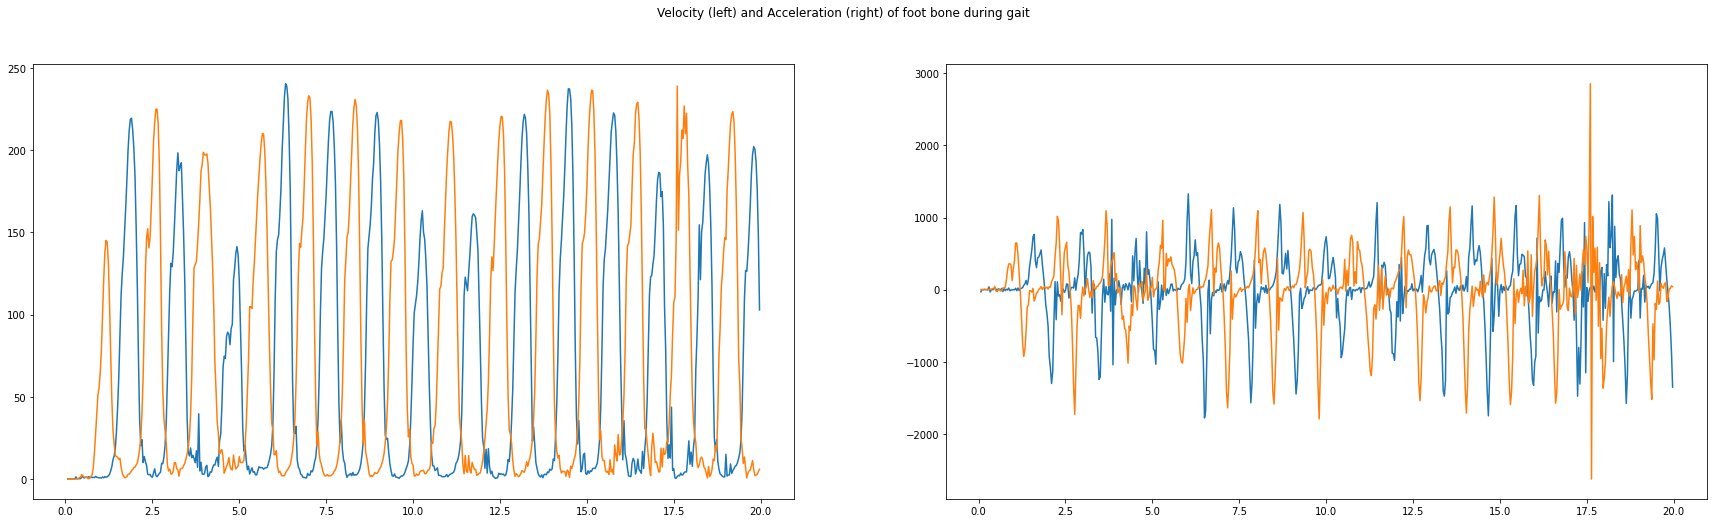

In [29]:
frm = 2
to = 600

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
fig.suptitle('Velocity (left) and Acceleration (right) of foot bone during gait')

time_axis_x = l_foot[("Time", "Time (Seconds)")][frm:to]
ax1.plot(time_axis_x, l_foot[("Velocity", "all")][frm:to])
ax1.plot(time_axis_x, r_foot[("Velocity", "all")][frm:to])

ax2.plot(time_axis_x, l_foot[("Acceleration", "all")][frm:to])
ax2.plot(time_axis_x, r_foot[("Acceleration", "all")][frm:to])
plt.show()

In [15]:
# IIR Filter
def iir_filter(data, n=20, a=1):
    b = [1.0 / n] * n
    return lfilter(b, a, data)

In [16]:
# Butter low pass filter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff=2.5, fs=150, order=10):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [30]:
l_foot_v_filtered = iir_filter(l_foot[("Velocity", "all")][frm:to])
r_foot_v_filtered = iir_filter(r_foot[("Velocity", "all")][frm:to])
l_foot_a_filtered = iir_filter(l_foot[("Acceleration", "all")][frm:to])
r_foot_a_filtered = iir_filter(r_foot[("Acceleration", "all")][frm:to])
#
# l_foot_v_filtered = butter_lowpass_filter(l_foot[("Velocity", "all")][frm:to])
# r_foot_v_filtered = butter_lowpass_filter(r_foot[("Velocity", "all")][frm:to])
# l_foot_a_filtered = butter_lowpass_filter(l_foot[("Acceleration", "all")][frm:to])
# r_foot_a_filtered = butter_lowpass_filter(r_foot[("Acceleration", "all")][frm:to])

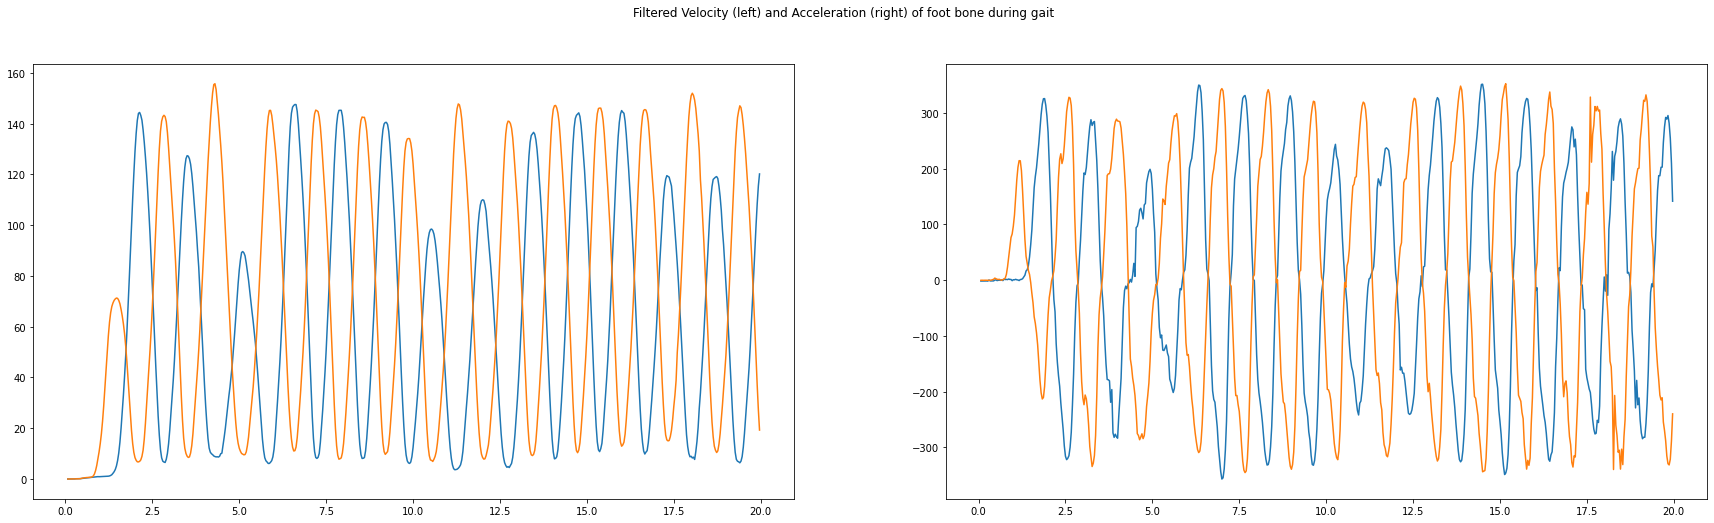

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
fig.suptitle('Filtered Velocity (left) and Acceleration (right) of foot bone during gait')
ax1.plot(time_axis_x, l_foot_v_filtered)
ax1.plot(time_axis_x, r_foot_v_filtered)
ax2.plot(time_axis_x, l_foot_a_filtered)
ax2.plot(time_axis_x, r_foot_a_filtered)

In [49]:
def calculate_valley_environment(data: np.ndarray, height=100, threshold=None, distance=20, prominence=100):
    valleys = find_valleys(data, height, threshold, distance, prominence)
    lowest_sum_environments = calculate_lowest_sum_environment(valleys, data)
    return lowest_sum_environments


def find_valleys(data: np.ndarray, height, threshold, distance, prominence):
    amax = np.amax(data)
    flipped_data = np.apply_along_axis(lambda x: x*-1 + amax, 0, data)
    valleys = find_peaks(flipped_data, height, threshold, distance, prominence)
    return valleys[0]


def calculate_avg_indices_distance(data: np.ndarray):
    avg_distance = 0
    length = len(data)
    for i in range(length):
        if i == length-1: break
        avg_distance += data[i+1] - data[i]
    avg_distance /= length
    return avg_distance


def calculate_lowest_sum_environment(valleys: np.ndarray, data:np.ndarray, width_factor=0.2):
    """

    :param valleys: list with indices of all valleys
    :param data: data to compute lowest sum environment for
    :param width_factor: Between 0 and 1. Gibt an wie breit jede Umgebung ist. 0 entspricht nur einem Punkt, 1 entspricht der Breite des durchschnittlichen Abstands zwischen 2 Punkten.
    :return: 2d array containing all indices for each valley enviromnent
    """
    average_distance = calculate_avg_indices_distance(valleys)

    width = int(width_factor * average_distance)

    lowest_sum_indices = []
    for valley in np.nditer(valleys):
        valley_lowest_sum = np.Infinity
        valley_lowest_sum_indices = []
        for starting_index in range(valley - width, valley):
            current_sum = np.sum(data[starting_index:starting_index+width])
            if current_sum < valley_lowest_sum:
                valley_lowest_sum = current_sum
                valley_lowest_sum_indices = list(range(starting_index, starting_index+width))
        lowest_sum_indices.append(valley_lowest_sum_indices)

    return np.asarray(lowest_sum_indices)

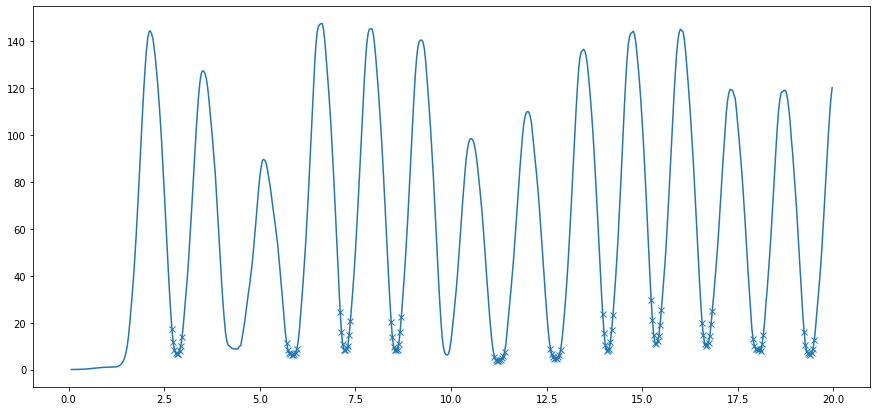

In [50]:
valley_environments = calculate_valley_environment(l_foot_v_filtered)
plt.figure(figsize=(15, 7))
plt.plot(time_axis_x, l_foot_v_filtered, '-x', markevery=np.ndarray.flatten(valley_environments))
plt.show()

In [26]:
centroids = []
for valley in valley_environments:
    centroids.append(list(l_foot.iloc[valley]["Position"].mean()))

cdist(centroids, centroids)

array([[  0.        ,  62.62716365,  39.08661004, 132.10830705,
        276.50085996, 254.92975713, 172.14398114,  85.15302014,
         65.66490109,  94.92462534,  94.38757841,  81.48084271,
        115.90325851, 190.00177455, 278.53515872, 177.47820348,
         81.77908231,  13.6799563 ],
       [ 62.62716365,   0.        , 101.11717938, 192.41172359,
        335.651227  , 316.98303342, 234.73584796, 145.39170352,
         85.36168821,  58.25293169,  34.04345256,  75.6482855 ,
        152.03252586, 235.79072616, 337.15758658, 236.24618501,
        141.46762401,  49.12610393],
       [ 39.08661004, 101.11717938,   0.        ,  93.35155973,
        237.91445572, 215.98331622, 134.72216705,  56.89451617,
         86.84973531, 131.61874839, 131.47063313,  99.3639867 ,
         98.07449626, 160.20937484, 240.14830852, 139.26270465,
         43.952874  ,  52.15840672],
       [132.10830705, 192.41172359,  93.35155973,   0.        ,
        144.58820305, 127.27650309,  67.88698108,  86.185